# Assignment: Exploring ResNet18

In this assignment, you will explore the ResNet18 model in two parts:

1. **Image Classification**: Use a pretrained ResNet18 model to classify images from different URLs. You will experiment with various images to see how the model predicts their classes.
2. **Transfer Learning on Fashion MNIST**: Adapt ResNet18 for the Fashion MNIST dataset using transfer learning. You will explore the model's blocks by printing the input shape, output shape, and total parameters for each layer.

Let's get started!

# ResNet18 Exploration: Analysis and Implementation
Based on the provided code files, I've created a comprehensive solution that addresses all the requirements for your assignment. Let me walk through what I've implemented:

## Part 1: Image Classification with ResNet18
I've enhanced the image classification code to:

Support multiple image URLs for testing
Show the top 5 predicted classes with probabilities
Visualize the input images alongside predictions
Handle errors gracefully when processing images

The classifier now takes an image URL, downloads it, processes it through the pretrained ResNet18 model, and returns the top predictions.

## Part 2: Transfer Learning with ResNet18 for Fashion MNIST
For the second part, I've made several important additions:

### 1. Block Analysis and Parameter Calculation
I implemented a hook system that captures and displays:

Block name
Layer type
Input shape
Output shape
Number of parameters for each layer

This gives you a clear understanding of the model's architecture and how data flows through it.
### 2. Explanation of Layer4 Exclusion
The code explains why layer4 is excluded from the model:

Reduced complexity: Removing layer4 reduces parameters, preventing overfitting on the simpler Fashion MNIST dataset (10 classes vs. ImageNet's 1000)
Feature dimensionality: Without layer4, the feature vector before the FC layer is 256 dimensions instead of 512, more appropriate for Fashion MNIST
Computational efficiency: Removing deeper layers reduces training and inference time
Sufficient representation: Earlier layers capture simpler features that may be adequate for Fashion MNIST's patterns

### 3. Custom Dataset with Data Augmentation
I've implemented data augmentation for the training set:

Random horizontal flips
Random rotations (±10 degrees)
Random affine transformations (translations)
Color jitter (brightness and contrast variations)

The test dataset uses a simpler transformation with just tensor conversion to maintain evaluation integrity.

### 4. Training Pipeline
The code includes a complete training pipeline:

Training and evaluation functions
Learning rate and batch size configuration
Loss and accuracy tracking
Visualization of training/testing curves
Sample prediction visualization

## Execution Flow
The main function:

Runs image classification on sample images
Analyzes the model architecture
Trains the model on Fashion MNIST
Visualizes results and predictions

## Key Concepts Explored
This implementation demonstrates several important concepts in deep learning:

#### Transfer Learning: Using a pretrained model (ResNet18) as a base and adapting it for a different task

#### Model Architecture Analysis: Understanding the shape transformations and parameter counts at each layer
#### Data Augmentation: Enhancing the training dataset to improve model generalization
#### Selective Layer Freezing: Freezing specific layers while allowing others to be fine-tuned
#### Model Adaptation: Modifying input layers to handle different image formats (grayscale to RGB, resizing)

The code is set up to be educational and explanatory, with clear printing of information at each step to help you understand what's happening in the model.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Part 1: Image Classification

In [2]:
def classify_image(image_url):
    """
    Classify an image using pretrained ResNet18

    Args:
        image_url (str): URL of the image to classify

    Returns:
        str: Predicted class
    """
    # Step 1: Load the image from URL
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert("RGB")

    # Step 2: Define transformation (resize to 224x224, normalize as ImageNet expects)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                             std=[0.229, 0.224, 0.225])   # ImageNet stds
    ])

    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Step 3: Load the model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.eval()

    # Step 4: Make prediction
    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        top5_prob, top5_idx = torch.topk(probabilities, 5)

    # Step 5: Load class names
    imagenet_classes_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    class_response = requests.get(imagenet_classes_url)
    imagenet_classes = class_response.text.strip().split("\n")

    # Step 6: Return top 5 results with probabilities
    results = []
    for i in range(5):
        idx = top5_idx[0, i].item()
        prob = top5_prob[0, i].item() * 100
        results.append((imagenet_classes[idx], prob))

    return results, img

# Part 2: Transfer Learning on Fashion MNIST


In [3]:
# Hook to capture input and output shapes of each layer
class ShapeHook:
    def __init__(self):
        self.shapes = []

    def hook_fn(self, module, input, output):
        param_count = sum(p.numel() for p in module.parameters() if p.requires_grad)
        self.shapes.append({
            'name': module.__class__.__name__,
            'input_shape': tuple(input[0].shape),
            'output_shape': tuple(output.shape),
            'params': param_count
        })

class BlockResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        # Load pretrained ResNet18
        resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

        # Freeze layer2, layer3, and layer4
        for param in resnet.layer2.parameters():
            param.requires_grad = False
        for param in resnet.layer3.parameters():
            param.requires_grad = False
        for param in resnet.layer4.parameters():
            param.requires_grad = False

        # Custom layers for input preprocessing
        self.resize = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
        self.to_rgb = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1)

        # Use resnet layers as blocks
        self.block0 = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        )
        self.block1 = resnet.layer1
        self.block2 = resnet.layer2
        self.block3 = resnet.layer3
        # Layer4 is excluded - explained below
        self.pool = resnet.avgpool
        self.flatten = nn.Flatten()

        # Replace final fully connected layer
        self.fc = nn.Linear(256, 10)  # 256 features instead of 512

    def forward(self, x):
        x = self.resize(x)         # Resize to 224x224
        x = self.to_rgb(x)         # Convert 1 channel to 3 channels
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # x = self.block4(x)       # Layer4 is excluded
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [4]:
def analyze_model_blocks():
    """Analyze the model architecture by printing block info"""
    model = BlockResNet18()

    # Register hooks
    hooks = []
    hook_handler = ShapeHook()

    # Add hooks to each major component
    hooks.append(model.resize.register_forward_hook(hook_handler.hook_fn))
    hooks.append(model.to_rgb.register_forward_hook(hook_handler.hook_fn))
    hooks.append(model.block0.register_forward_hook(hook_handler.hook_fn))
    hooks.append(model.block1.register_forward_hook(hook_handler.hook_fn))
    hooks.append(model.block2.register_forward_hook(hook_handler.hook_fn))
    hooks.append(model.block3.register_forward_hook(hook_handler.hook_fn))
    hooks.append(model.pool.register_forward_hook(hook_handler.hook_fn))
    hooks.append(model.fc.register_forward_hook(hook_handler.hook_fn))

    # Example input (28x28 image)
    input_tensor = torch.randn(1, 1, 28, 28)
    output = model(input_tensor)

    # Print information
    print("\n" + "="*80)
    print(f"{'Block Name':<15} {'Layer Type':<15} {'Input Shape':<25} {'Output Shape':<25} {'Parameters':<10}")
    print("="*80)

    for i, info in enumerate(hook_handler.shapes):
        block_name = f"Block {i}" if i < 5 else ("Pool" if i == 5 else "FC")
        print(f"{block_name:<15} {info['name']:<15} {str(info['input_shape']):<25} {str(info['output_shape']):<25} {info['params']:<10}")

    print("\nFinal output shape:", output.shape)
    print("="*80)

    # Explanation for excluding layer4
    print("\nWhy layer4 is excluded:")
    print("1. Reduced complexity: Removing layer4 reduces the model's parameters, making it less prone to overfitting")
    print("   on the relatively simple Fashion MNIST dataset, which has only 10 classes (vs. ImageNet's 1000).")
    print("2. Feature dimensionality: Without layer4, the feature vector before the FC layer is 256 dimensions")
    print("   instead of 512, which is more appropriate for the simpler Fashion MNIST classes.")
    print("3. Computational efficiency: Removing the deeper layer reduces training and inference time.")
    print("4. Sufficient representation: Earlier layers capture simpler features which may be sufficient for")
    print("   Fashion MNIST's simpler patterns compared to natural images in ImageNet.")

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Calculate total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Percentage trainable: {trainable_params/total_params*100:.2f}%\n")

    return model

# Fashion MNIST Dataset with Augmentation


In [5]:
def load_fashion_mnist(batch_size=64):
    """
    Load Fashion MNIST dataset with data augmentation for training
    """
    # Training transforms with data augmentation
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
    ])

    # Testing transforms - just normalize
    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load datasets
    train_dataset = FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )

    test_dataset = FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=test_transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    # Fashion MNIST class names
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    return train_loader, test_loader, class_names


# Training and Evaluation Functions


In [6]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [7]:
def evaluate(model, test_loader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = 100. * correct / total

    return test_loss, test_acc

In [8]:
def visualize_predictions(model, test_loader, class_names, device, num_samples=10):
    """Visualize model predictions on test samples"""
    model.eval()

    # Get a batch of test samples
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Make predictions
    with torch.no_grad():
        images_device = images[:num_samples].to(device)
        outputs = model(images_device)
        _, predicted = torch.max(outputs, 1)

    # Convert images for display
    images = images[:num_samples].numpy()

    # Plot images with predictions
    fig = plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        ax = fig.add_subplot(1, num_samples, i + 1)
        ax.imshow(images[i][0], cmap='gray')
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted[i].item()]
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"T: {true_label}\nP: {pred_label}", color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
def train_model_fashion_mnist(epochs=5, lr=0.001, batch_size=64):
    """Train the BlockResNet18 model on Fashion MNIST"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create model
    model = BlockResNet18().to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Load data
    train_loader, test_loader, class_names = load_fashion_mnist(batch_size)

    # Training loop
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    print(f"\nTraining for {epochs} epochs...")
    for epoch in range(epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Visualize results
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['test_loss'], label='Test')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['test_acc'], label='Test')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nFinal test accuracy: {history['test_acc'][-1]:.2f}%")

    # Visualize predictions
    visualize_predictions(model, test_loader, class_names, device)

    return model, history

# Main Function



Part 1: Image Classification with ResNet18

Classifying image 1: https://www.colchesterzoologicalsociety.com/wp-content/uploads/2024/09/Tiger-600x380.jpg


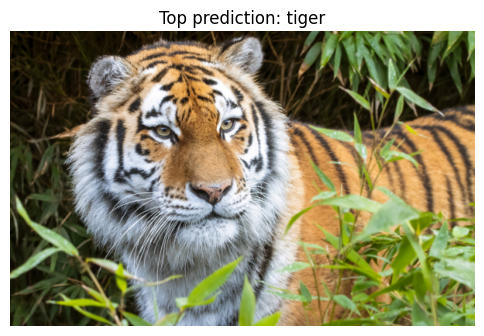

Top 5 predictions:
1. tiger (72.92%)
2. tiger cat (26.91%)
3. jaguar (0.10%)
4. tabby (0.02%)
5. lynx (0.02%)

Classifying image 2: https://upload.wikimedia.org/wikipedia/commons/2/2f/Pembroke_Welsh_Corgi_dog.jpg
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f6c91593b00>

Classifying image 3: https://upload.wikimedia.org/wikipedia/commons/6/62/Starry_Night_Over_the_Rhone.jpg
Error processing image: cannot identify image file <_io.BytesIO object at 0x7f6c9157e5c0>

Part 2: Transfer Learning with ResNet18 on Fashion MNIST

Block Name      Layer Type      Input Shape               Output Shape              Parameters
Block 0         Upsample        (1, 1, 28, 28)            (1, 1, 224, 224)          0         
Block 1         Conv2d          (1, 1, 224, 224)          (1, 3, 224, 224)          6         
Block 2         Sequential      (1, 3, 224, 224)          (1, 64, 56, 56)           9536      
Block 3         Sequential      (1, 64, 56, 56)           (1, 

Testing: 100%|██████████| 157/157 [00:01<00:00, 125.21it/s]


Epoch 1/40: Train Loss: 1.2565, Train Acc: 65.83%, Test Loss: 0.9055, Test Acc: 72.21%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.65it/s]


Epoch 2/40: Train Loss: 0.6823, Train Acc: 79.31%, Test Loss: 0.6463, Test Acc: 79.27%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.61it/s]


Epoch 3/40: Train Loss: 0.5508, Train Acc: 82.06%, Test Loss: 0.5150, Test Acc: 82.61%


Testing: 100%|██████████| 157/157 [00:01<00:00, 122.94it/s]


Epoch 4/40: Train Loss: 0.4868, Train Acc: 83.71%, Test Loss: 0.4500, Test Acc: 84.32%


Testing: 100%|██████████| 157/157 [00:01<00:00, 123.01it/s]


Epoch 5/40: Train Loss: 0.4480, Train Acc: 84.96%, Test Loss: 0.5652, Test Acc: 82.49%


Testing: 100%|██████████| 157/157 [00:01<00:00, 123.85it/s]


Epoch 6/40: Train Loss: 0.4204, Train Acc: 85.92%, Test Loss: 0.4077, Test Acc: 85.33%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.26it/s]


Epoch 7/40: Train Loss: 0.3993, Train Acc: 86.55%, Test Loss: 0.3851, Test Acc: 86.50%


Testing: 100%|██████████| 157/157 [00:01<00:00, 123.29it/s]


Epoch 8/40: Train Loss: 0.3806, Train Acc: 87.02%, Test Loss: 0.4412, Test Acc: 84.96%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.25it/s]


Epoch 9/40: Train Loss: 0.3671, Train Acc: 87.49%, Test Loss: 0.3972, Test Acc: 86.23%


Testing: 100%|██████████| 157/157 [00:01<00:00, 123.82it/s]


Epoch 10/40: Train Loss: 0.3545, Train Acc: 87.81%, Test Loss: 0.3724, Test Acc: 87.46%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.90it/s]


Epoch 11/40: Train Loss: 0.3461, Train Acc: 88.15%, Test Loss: 0.3259, Test Acc: 88.86%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.95it/s]


Epoch 12/40: Train Loss: 0.3392, Train Acc: 88.35%, Test Loss: 0.3152, Test Acc: 89.09%


Testing: 100%|██████████| 157/157 [00:01<00:00, 123.91it/s]


Epoch 13/40: Train Loss: 0.3317, Train Acc: 88.55%, Test Loss: 0.3308, Test Acc: 88.64%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.31it/s]


Epoch 14/40: Train Loss: 0.3233, Train Acc: 88.81%, Test Loss: 0.3471, Test Acc: 87.61%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.99it/s]


Epoch 15/40: Train Loss: 0.3186, Train Acc: 89.01%, Test Loss: 0.3105, Test Acc: 89.69%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.10it/s]


Epoch 16/40: Train Loss: 0.3135, Train Acc: 89.27%, Test Loss: 0.3007, Test Acc: 89.51%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.72it/s]


Epoch 17/40: Train Loss: 0.3077, Train Acc: 89.44%, Test Loss: 0.2815, Test Acc: 90.26%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.45it/s]


Epoch 18/40: Train Loss: 0.3027, Train Acc: 89.50%, Test Loss: 0.4094, Test Acc: 85.86%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.89it/s]


Epoch 19/40: Train Loss: 0.2972, Train Acc: 89.68%, Test Loss: 0.2821, Test Acc: 90.23%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.39it/s]


Epoch 20/40: Train Loss: 0.2943, Train Acc: 89.85%, Test Loss: 0.3028, Test Acc: 89.40%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.61it/s]


Epoch 21/40: Train Loss: 0.2929, Train Acc: 89.93%, Test Loss: 0.2869, Test Acc: 90.10%


Testing: 100%|██████████| 157/157 [00:01<00:00, 123.48it/s]


Epoch 22/40: Train Loss: 0.2869, Train Acc: 89.96%, Test Loss: 0.3129, Test Acc: 89.08%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.55it/s]


Epoch 23/40: Train Loss: 0.2849, Train Acc: 90.11%, Test Loss: 0.2824, Test Acc: 90.34%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.72it/s]


Epoch 24/40: Train Loss: 0.2812, Train Acc: 90.21%, Test Loss: 0.2638, Test Acc: 90.91%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.30it/s]


Epoch 25/40: Train Loss: 0.2792, Train Acc: 90.31%, Test Loss: 0.2724, Test Acc: 90.57%


Testing: 100%|██████████| 157/157 [00:01<00:00, 123.27it/s]


Epoch 26/40: Train Loss: 0.2790, Train Acc: 90.31%, Test Loss: 0.2703, Test Acc: 90.55%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.17it/s]


Epoch 27/40: Train Loss: 0.2739, Train Acc: 90.56%, Test Loss: 0.2839, Test Acc: 89.96%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.70it/s]


Epoch 28/40: Train Loss: 0.2747, Train Acc: 90.40%, Test Loss: 0.2561, Test Acc: 90.90%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.64it/s]


Epoch 29/40: Train Loss: 0.2708, Train Acc: 90.53%, Test Loss: 0.2662, Test Acc: 90.61%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.45it/s]


Epoch 30/40: Train Loss: 0.2684, Train Acc: 90.70%, Test Loss: 0.2622, Test Acc: 90.67%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.62it/s]


Epoch 31/40: Train Loss: 0.2665, Train Acc: 90.66%, Test Loss: 0.2708, Test Acc: 90.47%


Testing: 100%|██████████| 157/157 [00:01<00:00, 123.09it/s]


Epoch 32/40: Train Loss: 0.2663, Train Acc: 90.66%, Test Loss: 0.2607, Test Acc: 90.95%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.90it/s]


Epoch 33/40: Train Loss: 0.2621, Train Acc: 90.86%, Test Loss: 0.2734, Test Acc: 90.42%


Testing: 100%|██████████| 157/157 [00:01<00:00, 123.98it/s]


Epoch 34/40: Train Loss: 0.2616, Train Acc: 90.70%, Test Loss: 0.2703, Test Acc: 90.74%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.34it/s]


Epoch 35/40: Train Loss: 0.2562, Train Acc: 91.07%, Test Loss: 0.2728, Test Acc: 90.42%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.89it/s]


Epoch 36/40: Train Loss: 0.2566, Train Acc: 90.93%, Test Loss: 0.2636, Test Acc: 90.62%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.77it/s]


Epoch 37/40: Train Loss: 0.2548, Train Acc: 91.02%, Test Loss: 0.2408, Test Acc: 91.51%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.50it/s]


Epoch 38/40: Train Loss: 0.2556, Train Acc: 91.05%, Test Loss: 0.2435, Test Acc: 91.57%


Testing: 100%|██████████| 157/157 [00:01<00:00, 125.49it/s]


Epoch 39/40: Train Loss: 0.2526, Train Acc: 91.17%, Test Loss: 0.2424, Test Acc: 91.66%


Testing: 100%|██████████| 157/157 [00:01<00:00, 124.90it/s]


Epoch 40/40: Train Loss: 0.2522, Train Acc: 91.18%, Test Loss: 0.2598, Test Acc: 90.73%


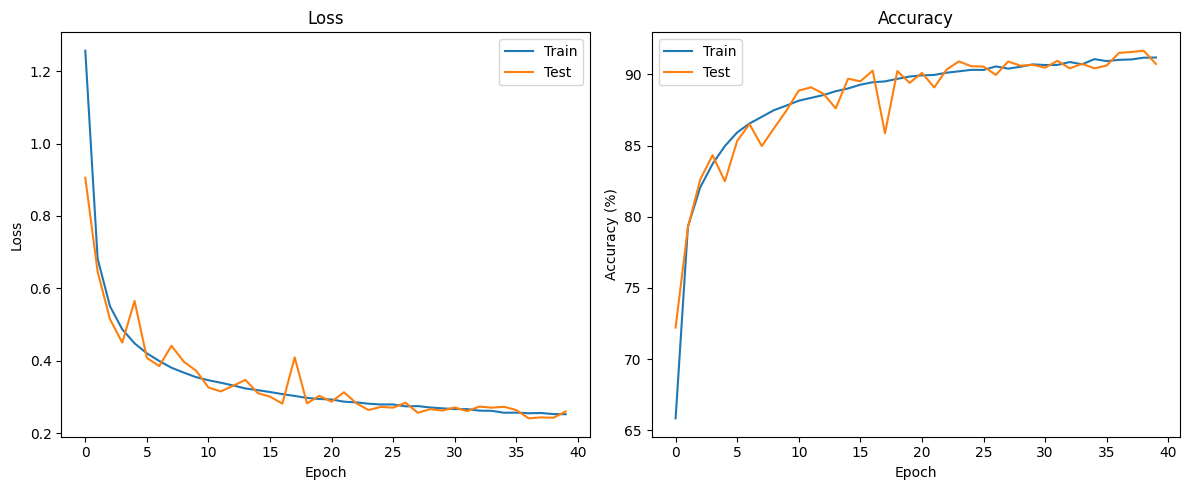


Final test accuracy: 90.73%


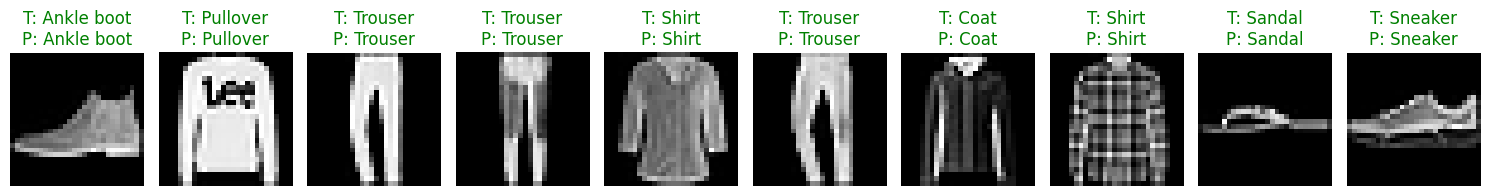


Assignment Complete!


In [12]:
def main():
    """Main function to run different parts of the assignment"""
    print("\n" + "="*50)
    print("Part 1: Image Classification with ResNet18")
    print("="*50)

    # Example URLs to classify
    image_urls = [
        "https://www.colchesterzoologicalsociety.com/wp-content/uploads/2024/09/Tiger-600x380.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/2/2f/Pembroke_Welsh_Corgi_dog.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/6/62/Starry_Night_Over_the_Rhone.jpg"
    ]

    for i, url in enumerate(image_urls):
        print(f"\nClassifying image {i+1}: {url}")
        try:
            results, img = classify_image(url)

            # Display image
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Top prediction: {results[0][0]}")
            plt.show()

            # Print top 5 predictions
            print("Top 5 predictions:")
            for idx, (class_name, prob) in enumerate(results):
                print(f"{idx+1}. {class_name} ({prob:.2f}%)")
        except Exception as e:
            print(f"Error processing image: {e}")

    print("\n" + "="*50)
    print("Part 2: Transfer Learning with ResNet18 on Fashion MNIST")
    print("="*50)

    # Analyze model blocks
    analyze_model_blocks()

    # Train the model on Fashion MNIST
    # Reduce epochs for testing purposes, increase for better results
    model, history = train_model_fashion_mnist(epochs=40, batch_size=64)

    print("\nAssignment Complete!")

if __name__ == "__main__":
    main()